# Default Pytorch pruning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import fastprogress
import fastai
from fastai import *
from fastai.text import *
from fastai.vision import *

In [3]:
bs = 64
epochs = 3

In [4]:
class Net(nn.Module):
    def __init__(self, mnist=True):
        super().__init__()
          
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.bn2 = nn.BatchNorm2d(50)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
path = untar_data(URLs.MNIST)

In [6]:
data = (ImageList.from_folder(path)
                .split_by_folder(train='training', valid='testing')
                .label_from_folder()
                .databunch()
                .normalize())

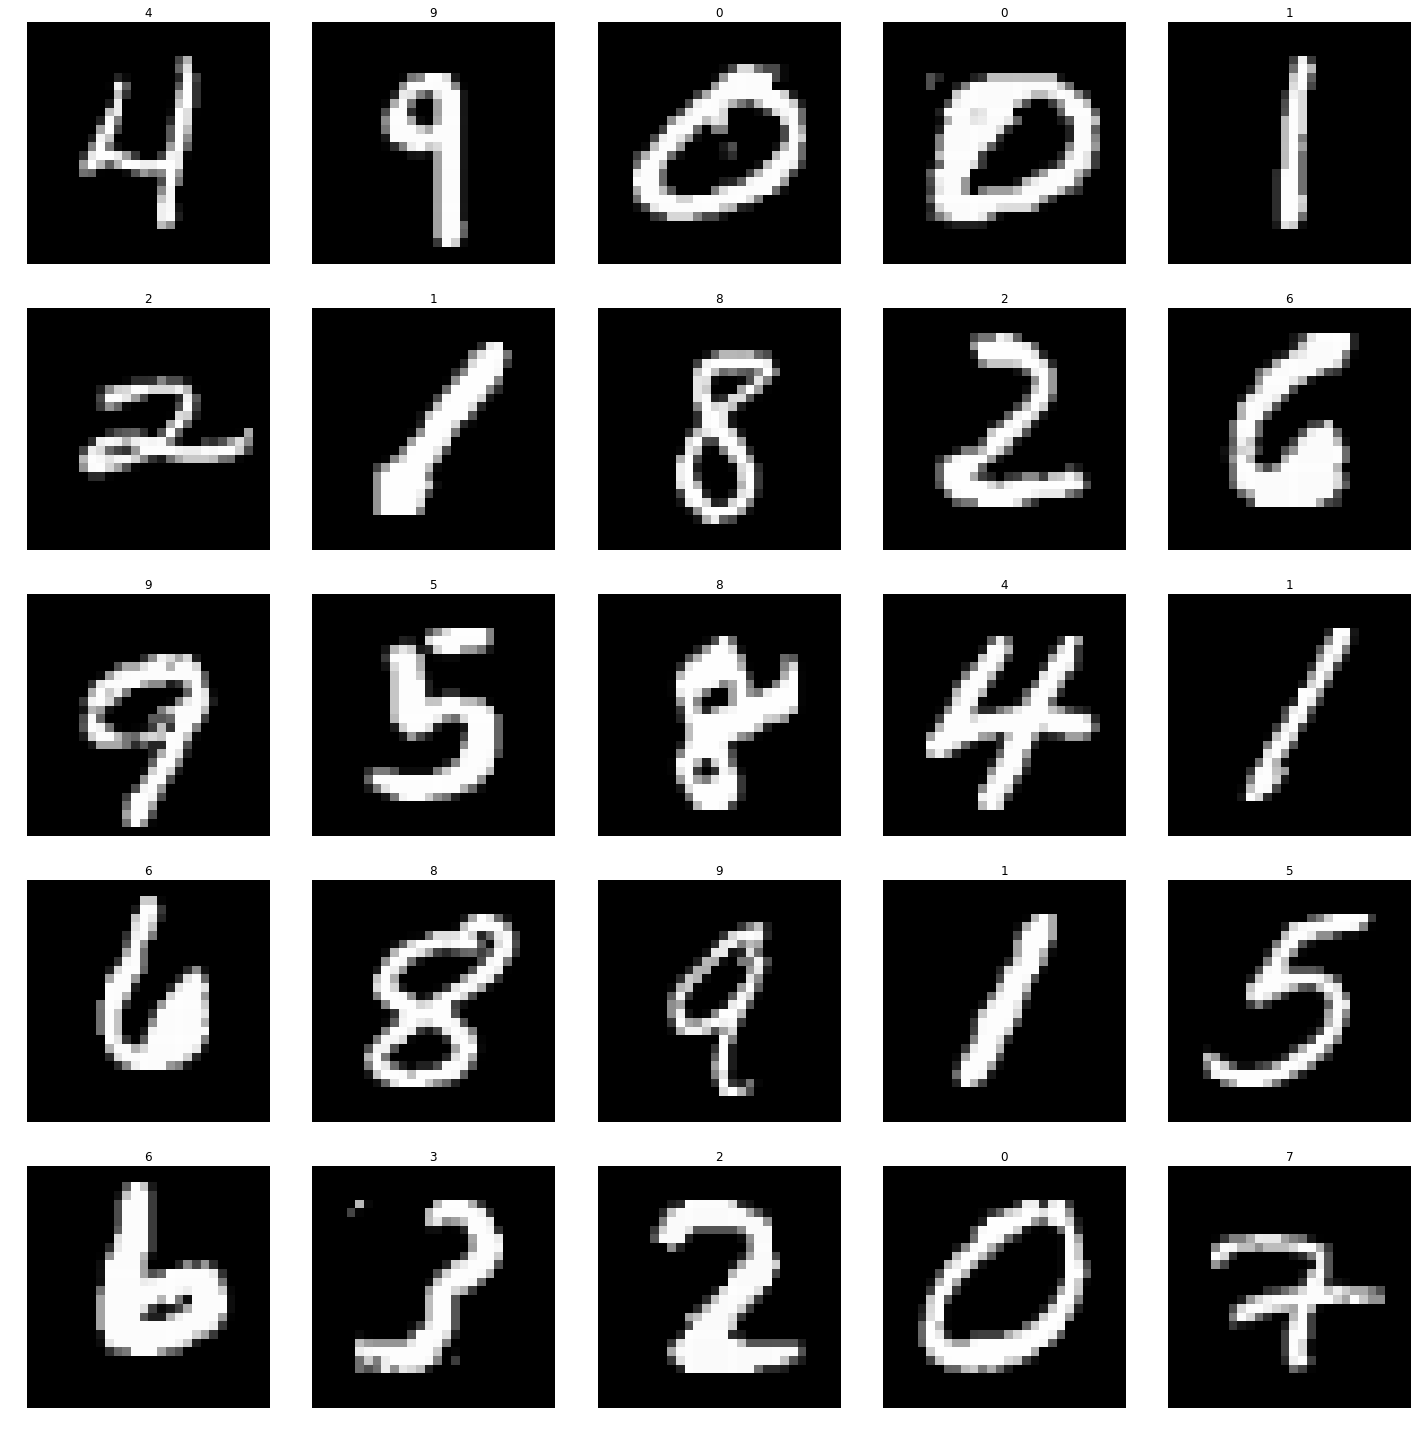

In [7]:
data.show_batch()

### Filter Pruning

In [8]:
prune_meta = {
        "starting_step" : 100,
        "current_step": 0,
        "ending_step": epochs * len(data.train_dl),
        "final_sparsity": 90,
        "initial_sparsity": 0,
        "span": 100
    }

In [9]:
class Sparsifier():
    def __init__(self, meta):
        self.meta = meta
    
    def _compute_sparsity(self, meta):
        return meta['final_sparsity'] + (meta['initial_sparsity'] - meta['final_sparsity'])*(1 - (meta['current_step'] - meta['starting_step'])/((meta['ending_step'] - meta['starting_step'])))**3

    def prune(self, model, meta):
  
        binary_masks = {}
  
        sparsity = self._compute_sparsity(meta)
    
        for k, m in enumerate(model.children()):

            if isinstance(m, nn.Conv2d):
                
                print('Conv')

                # Prune the weights
                weight = m.weight.data.abs().sum(dim=(1,2,3))
                y, i = torch.sort(weight)

                spars_index = int(weight.shape[0]*sparsity/100)
                threshold = y[spars_index]
                mask = weight.gt(threshold).float().cuda()
      
                binary_masks[k] = mask.view(-1,1,1,1)
                m.weight.data.mul_(mask.view(-1,1,1,1))
            
            
                # Prune the biases
                m.bias.data.mul_(mask)
                
            
            if isinstance(m, nn.BatchNorm2d):
                
                print('BN')
                
                m.weight.data.mul_(mask)
                m.bias.data.mul_(mask)
                m.running_mean.mul_(mask)
                m.running_var.mul_(mask)
                
  
        return model, binary_masks    
        

    def applyBinaryMasks(self, model, masks):
  
        for k, m in enumerate(model.children()):

            if isinstance(m, nn.Conv2d):
                mask = masks[k]
                m.weight.data.mul_(mask)
    
        return model

@dataclass
class SparsifyCallback(Callback):
    learn:Learner
        
    def __init__(self, meta):
        self.meta = meta
        self.sparsifier = Sparsifier(self.meta)
        self.binary_masks = None
        
    def on_epoch_end(self, **kwargs):
        print(f'Current model sparsity: {self.sparsifier._compute_sparsity(self.meta):.2f} %')
        
    def on_batch_end(self, **kwargs):
        
        if learn.model.training: # To avoid pruning during the validation phase
            self.meta['current_step'] += 1

        if self.binary_masks:
            learn.model = self.sparsifier.applyBinaryMasks(learn.model, self.binary_masks)
          
        
        if (self.meta['current_step'] - self.meta['starting_step']) % self.meta['span'] == 0 and self.meta['current_step'] > self.meta['starting_step']: 
            learn.model, self.binary_masks = self.sparsifier.prune(learn.model, self.meta)
    


In [10]:
learn = Learner(data, Net().cuda(), callbacks=SparsifyCallback(meta=prune_meta), metrics=accuracy)

In [11]:
learn.fit(epochs, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.059443,0.046203,0.984600,00:17
1,0.127330,0.103669,0.965900,00:18
2,0.080542,0.079729,0.975400,00:19


Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Current model sparsity: 60.27 %
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Current model sparsity: 86.28 %
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Conv
BN
Current model sparsity: 90.00 %


In [12]:
def model_stats(model):
        for k, m in enumerate(model.modules()):

            if not isinstance(m, Net):

                weight = m.weight.data.view(-1).clone().abs()
                non_zero_weights = weight.gt(0).float().cuda().sum()                
                total_weights = weight.shape[0]
                zero_weights = 100 - int(non_zero_weights*100/total_weights)
                print(m)
                print("Percentage of zero weights: ", zero_weights)

In [13]:
model_stats(learn.model)

Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
Percentage of zero weights:  90
BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Percentage of zero weights:  0
Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
Percentage of zero weights:  90
BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Percentage of zero weights:  0
Linear(in_features=800, out_features=500, bias=True)
Percentage of zero weights:  0
Linear(in_features=500, out_features=10, bias=True)
Percentage of zero weights:  0


In [14]:
l = learn.model.children()

In [17]:
m = next(iter(l))

In [18]:
m

BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [19]:
m.weight

Parameter containing:
tensor([ 2.2281e-43,  1.3656e-41,  1.1053e-40,  2.4143e-41, -1.6528e-40,
        -1.0793e-40, -6.0948e-40,  8.4531e-40, -4.3667e-41,  3.2300e-01,
         2.8995e-40,  1.0787e-39, -1.0229e-42, -1.4395e-39, -8.9999e-40,
         5.4146e-40,  2.6608e-01, -7.7071e-44, -5.2759e-42, -3.3281e-42],
       device='cuda:0', requires_grad=True)